In [2]:
from notes.notebooks import *

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Oct 14 2023

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.15.0

numpy     : 1.22.3
pandas    : 2.0.3
sys       : 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
numba     : 0.57.1
matplotlib: 3.7.2
seaborn   : 0.12.2
logging   : 0.5.1.2

Watermark: 2.4.3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here I demonstrate solving linear regression problem with breakpoints using a hybrid of [CUSUM](https://en.wikipedia.org/wiki/CUSUM) and [Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization) on synthetic data.

*Setting*
We're in an online OLS setting $y \sim N(Xb + \mu, \sigma)$ where $y \in R^n$, $X \in R^{n \times p}$ and $b \in R^p$. The data comes in chunks, with $c_i$ representing the set of samples in chunk $i$, and the true "inferrables" ($b, \mu$ and $\sigma$) can change from chunk to chunk in a jump-like fashion.

*Proposed solution*
I suggest to do the following on a rolling window:
- standardize the features and the response.
- fit an `ElasticNet` on all the chunks.
- put breakpoints using CUSUM:
    - a breakpoint is when either one of $\hat{b}, \hat\mu, \hat\sigma$ changes "drastically";
    - changes in $\hat{b}$ are inferred by running CUSUM on the correlations between the residuals and the individual covariates;
    - I put a limit on how frequently one can put down a breakpoint (i.e., min number of chunks observed).
- reweigh the data based on inferred sequence of $\sigma$s and perform `ElasticNet` with dummy variables for each breakpoint interval. Note that if a breakpoint interval was introduced due to change in $\mu$, I don't put a dummy variable in for $\hat{b}$.
- to predict for the upcoming chunk, I use the coefficients which correspond to the interval after the very last break.
The target metric is RMSE, and I'll generate a validation split with novel synthetic data (i.e. true parameters are far from the center of the params used to tune hyperparams), to see how well the fitting strategy works.

*Synthetic data*
- For simplicity, I let $p=2$ and $b_2=0$, i.e. $y$ only depends on the first column of $X$.
- I set a total of $100$ chunks for hyperparam fitting, and $50$ for validation, each with $200$ observations.
- The data $X$ is formed by taking a cumulative sum of a random walk and differing it over $400$ observations.
- I put in breaks for $b, \mu, \sigma$ "manually"; see the plots below.

In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [21]:
b.shape

(25000,)

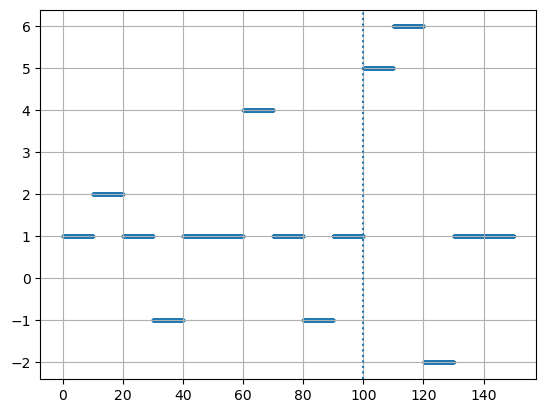

In [24]:
p = 2
n_chunks_tune = 100
n_chunks_validate = 50
nobs_per_chunk = 200
x_diff_steps = 400
n_tune = n_chunks_tune * nobs_per_chunk
n_validate = n_chunks_validate * nobs_per_chunk
n = n_tune + n_validate
mu = np.repeat(np.r_[
    np.repeat([1, 2, 1, -1, 1, 1, 4, 1, -1, 1], 10),  # tune
    np.repeat([5, 6, -2, 1, 0], 10),  # validate
], nobs_per_chunk)
index = np.linspace(0, n_chunks_tune + n_chunks_validate, n + 1)[1:]

b =

plt.scatter(index, mu, s=2., alpha=.5, label='mean')
plt.axvline(n_chunks_tune, linestyle='dotted')
plt.grid()
plt.legend()

def generate_data(seed=1):
    np.random.seed(seed)
    x = np.cumsum(np.random.randn(n + x_diff_steps, p), axis=0)
    return (x[x_diff_steps:] - x[:-x_diff_steps]) / np.sqrt(nobs_per_chunk)

In [13]:
x = generate_data()

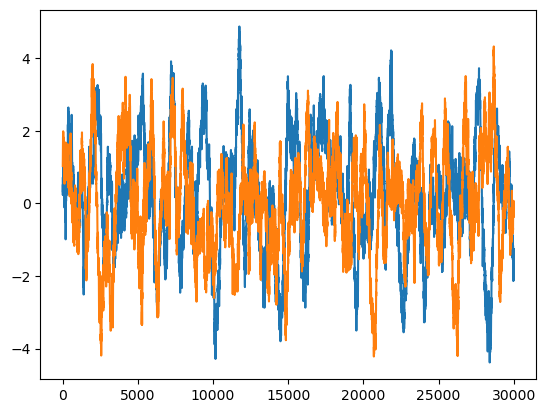

In [15]:
plt.plot(x[:, 0])
plt.plot(x[:, 1])

In [ ]:
# creating a synthetic sample

def generate_sample()

In [5]:
from notes.ml import regime_change

In [32]:
n = 100
m = 10
x = np.random.randn(2 * n * m) + np.tile(np.r_[np.zeros(n), np.ones(n)], m)

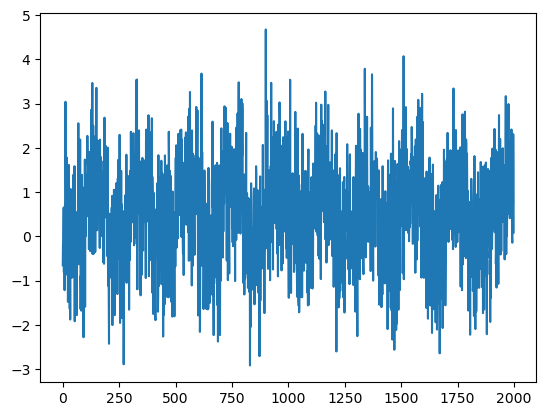

In [33]:
plt.plot(x)

In [36]:
regime_change.cusum_breakpoints(x, 2, 1, min_obs_to_break=20)

array([   0,  110,  131,  151,  185,  205,  271,  304,  325,  370,  471,
        525,  545,  565,  590,  615,  717,  737,  757,  777,  797,  900,
        924,  944,  964,  987, 1008, 1123, 1148, 1168, 1188, 1304, 1339,
       1368, 1392, 1504, 1525, 1545, 1565, 1585, 1661, 1706, 1732, 1759,
       1779, 1912, 1934, 1964])